### Apply layer-parallel Torchbraid to simple MNIST problem (fashion or digits)
- See `start0_install_mpi_notebook.ipynb`, and `start1_simple_mpi_notebook.ipynb` for setting up MPI-compatible Jupyter installation
- Recommended to start ipython cluster for default notebook settings with (assumes 4 cores)

        $ ipcluster start --n=4 --engines=mpi --profile=mpi

  or

        $ ipcluster start --n=4 --engines=MPIEngineSetLauncher --profile=mpi
        
#### Layer-parallel runs most efficiently when the 

    (number of processors)*(coarsening factor) = k*(number of ResNet Layers)
    
where `k` is some integer. This experiment is designed to satisfy this with the default parameters and four processors.

In [6]:
# Connect to local ipython cluster.  Note, the ipcluster profile name must match the
# below named profile. Here, we use 'mpi', but you can name the cluster profile anything
from ipyparallel import Client, error
cluster = Client(profile='mpi')
print('profile:', cluster.profile)
print("IDs:", cluster.ids) 

profile: mpi
IDs: [0, 1, 2, 3]


In [7]:
%%px
# You must upate the sys.path to point to your Torchbraid location
from __future__ import print_function

import statistics as stats
import sys
from timeit import default_timer as timer

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from mpi4py import MPI

import sys 
sys.path.append("/Users/jacobschroder/joint_repos/torchbraid/torchbraid_py3_10/torchbraid")
sys.path.append("/Users/jacobschroder/joint_repos/torchbraid/torchbraid_py3_10")
import torchbraid
import torchbraid.utils

In [8]:
# Download the data
from torchvision import datasets, transforms
datasets.MNIST('./digit-data', download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./digit-data
    Split: Train

In [9]:
%%px
# Network architecture is Open + ResNet + Close
# The StepLayer defines the ResNet (ODENet) 
class OpenFlatLayer(nn.Module):
  ''' 
  Opening layer has no parameters, replicates image number of channels times
  '''
  def __init__(self, channels):
    super(OpenFlatLayer, self).__init__()
    self.channels = channels

  def forward(self, x):
    s = len(x.shape) * [1]
    s[1] = self.channels
    x = x.repeat(s)
    return x

class CloseLayer(nn.Module):
  '''
  Dense closing classification layer
  '''
  def __init__(self, channels):
    super(CloseLayer, self).__init__()
    self.fc1 = nn.Linear(channels * 28 * 28, 32)
    self.fc2 = nn.Linear(32, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

class StepLayer(nn.Module):
  '''
  ResNet composed of convolutional layers
  '''
  def __init__(self, channels):
    super(StepLayer, self).__init__()
    ker_width = 3
    self.conv1 = nn.Conv2d(channels, channels, ker_width, padding=1)
    self.conv2 = nn.Conv2d(channels, channels, ker_width, padding=1)

  def forward(self, x):
    return F.relu(self.conv2(F.relu(self.conv1(x))))

In [10]:
%%px
# Parallel network class, primarily builds a LayerParallel network object
# local_steps: number of ResNet layers per processor
# for definitions of layer-parallel (and other parameters) see more advanced scripts and notebooks
class ParallelNet(nn.Module):
  def __init__(self, channels=3, local_steps=32, Tf=1.0, max_levels=3, bwd_max_iters=1, 
               fwd_max_iters=2, print_level=0, braid_print_level=0, cfactor=4, 
               fine_fcf=False, skip_downcycle=True, fmg=False, relax_only_cg=0,
               user_mpi_buf=False, gpu_direct_commu=False):
    super(ParallelNet, self).__init__()

    step_layer = lambda: StepLayer(channels)
    numprocs = MPI.COMM_WORLD.Get_size()
    
    self.parallel_nn = torchbraid.LayerParallel(MPI.COMM_WORLD, step_layer, local_steps*numprocs, Tf,
                                                max_fwd_levels=max_levels, max_bwd_levels=max_levels,
                                                max_iters=2, user_mpi_buf=user_mpi_buf,
                                                gpu_direct_commu=gpu_direct_commu)
    self.parallel_nn.setBwdMaxIters(bwd_max_iters)
    self.parallel_nn.setFwdMaxIters(fwd_max_iters)
    self.parallel_nn.setPrintLevel(print_level, True)
    self.parallel_nn.setPrintLevel(braid_print_level, False)
    self.parallel_nn.setCFactor(cfactor)
    self.parallel_nn.setSkipDowncycle(skip_downcycle)
    self.parallel_nn.setBwdRelaxOnlyCG(relax_only_cg)
    self.parallel_nn.setFwdRelaxOnlyCG(relax_only_cg)
    if fmg:
      self.parallel_nn.setFMG()
    
    self.parallel_nn.setNumRelax(1)  # FCF relaxation default on coarse levels
    if not fine_fcf:
      self.parallel_nn.setNumRelax(0, level=0)  # Set F-Relaxation only on the fine grid
    else:
      self.parallel_nn.setNumRelax(1, level=0)  # Set FCF-Relaxation on the fine grid

    # this object ensures that only the LayerParallel code runs on ranks!=0
    compose = self.compose = self.parallel_nn.comp_op()

    # by passing this through 'compose' (mean composition: e.g. OpenFlatLayer o channels)
    # on processors not equal to 0, these will be None (there are no parameters to train there)
    self.open_nn = compose(OpenFlatLayer, channels)
    self.close_nn = compose(CloseLayer, channels)

  def forward(self, x):
    # by passing this through 'o' (mean composition: e.g. self.open_nn o x)
    # this makes sure this is run on only processor 0

    x = self.compose(self.open_nn, x)
    x = self.parallel_nn(x)
    x = self.compose(self.close_nn, x)

    return x


In [11]:
%%px
# Train model for one epoch
# Return values: per batch losses and training times, model parameters updated in-place
def train(rank, params, model, train_loader, optimizer, epoch, compose, device):
  train_times = []
  losses = []
  model.train()
  criterion = nn.CrossEntropyLoss()
  total_time = 0.0
  for batch_idx, (data, target) in enumerate(train_loader):
    start_time = timer()
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = compose(criterion, output, target)
    loss.backward()
    stop_time = timer()
    optimizer.step()

    total_time += stop_time - start_time
    train_times.append(stop_time - start_time)
    losses.append(loss.item())
    if batch_idx % 10 == 0:
      root_print(rank, 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime Per Batch {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
               100. * batch_idx / len(train_loader), loss.item(), total_time / (batch_idx + 1.0)))

  root_print(rank, 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime Per Batch {:.6f}'.format(
    epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
           100. * (batch_idx + 1) / len(train_loader), loss.item(), total_time / (batch_idx + 1.0)))
  return losses, train_times

In [12]:
%%px
# Evaluate model on validation data
# Return: number of correctly classified test items, total number of test items, loss on test data set
def test(rank, model, test_loader, compose, device):
  model.eval()
  test_loss = 0
  correct = 0
  criterion = nn.CrossEntropyLoss()
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += compose(criterion, output, target).item()

      if rank == 0:
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  root_print(rank, '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return correct, len(test_loader.dataset), test_loss

# Parallel printing helper function
def root_print(rank, s):
  if rank == 0:
    print(s)

In [13]:
%%px
# Begin setting up run-time environment 

#Set a few training parameters  
params = {}
params['percent_data'] = 0.05 # how much of the data to read in and use for training/testing
params['batch_size'] = 50     # input batch size for training
params['epochs'] = 3          # number of epochs to train
params['lr'] = 0.01           # learning rate
params['steps'] = 32          # number of times steps in the resnet layer-parallel part

# MPI information
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
procs = comm.Get_size()

# Use device or CPU?
use_cuda = torch.cuda.is_available()
device, host = torchbraid.utils.getDevice(comm=comm)
device = torch.device("cuda" if use_cuda else "cpu")
print(f'Run info rank: {rank}: | Device: {device} | Host: {host}')

# Set seed for reproducibility
torch.manual_seed(1)

# Compute number of steps in ResNet per processor
local_steps = 32 / procs
if params['steps'] % procs != 0:
  root_print(rank, 'Steps must be an even multiple of the number of processors: %d %d' % (params['steps'], procs))


[stdout:1] Run info rank: 1: | Device: cpu | Host: cpu


[stdout:0] No GPUs to be used, CPU only
Run info rank: 0: | Device: cpu | Host: cpu


[stdout:2] Run info rank: 2: | Device: cpu | Host: cpu


[stdout:3] Run info rank: 3: | Device: cpu | Host: cpu


In [14]:
%%px
# Read in Digits MNIST 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)) ])
dataset = datasets.MNIST('./digit-data', download=False, transform=transform)
train_size = int(50000 * params['percent_data'])
test_size = int(10000 * params['percent_data'])
train_set = torch.utils.data.Subset(dataset, range(train_size))
test_set = torch.utils.data.Subset(dataset, range(train_size, train_size + test_size))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=params['batch_size'], shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=params['batch_size'], shuffle=False)

In [15]:
%%px
# Create layer-parallel network
# Note this can be done on only one processor, but will be slow
model = ParallelNet(local_steps=local_steps).to(device)

# Declare optimizer
optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)

# Carry out parallel training
batch_losses = []; batch_times = []
epoch_times = []; test_times = []
validat_correct_counts = []

for epoch in range(1, params['epochs'] + 1):
  start_time = timer()
  [losses, train_times] = train(rank=rank, params=params, model=model, train_loader=train_loader, optimizer=optimizer, epoch=epoch,
        compose=model.compose, device=device)
  epoch_times += [timer() - start_time]
  batch_losses += losses
  batch_times += train_times

  start_time = timer()
  validat_correct, validat_size, validat_loss = test(rank=rank, model=model, test_loader=test_loader, compose=model.compose, device=device)
  test_times += [timer() - start_time]
  validat_correct_counts += [validat_correct]

root_print(rank,
           f'TIME PER EPOCH: {"{:.2f}".format(stats.mean(epoch_times))} '
           f'{("(1 std dev " + "{:.2f}".format(stats.mean(epoch_times))) if len(epoch_times) > 1 else ""}')
root_print(rank,
           f'TIME PER TEST:  {"{:.2f}".format(stats.mean(test_times))} '
           f'{("(1 std dev " + "{:.2f}".format(stats.mean(test_times))) if len(test_times) > 1 else ""}')

[stdout:0] Train Epoch: 1 [0/2500 (0%)]	Loss: 2.284102	Time Per Batch 0.248401
Train Epoch: 1 [500/2500 (20%)]	Loss: 1.639556	Time Per Batch 0.267680
Train Epoch: 1 [1000/2500 (40%)]	Loss: 0.773405	Time Per Batch 0.276539
Train Epoch: 1 [1500/2500 (60%)]	Loss: 0.555776	Time Per Batch 0.272132
Train Epoch: 1 [2000/2500 (80%)]	Loss: 0.716988	Time Per Batch 0.268789
Train Epoch: 1 [2500/2500 (100%)]	Loss: 0.452535	Time Per Batch 0.266959

Test set: Average loss: 0.0088, Accuracy: 443/500 (89%)

Train Epoch: 2 [0/2500 (0%)]	Loss: 0.469672	Time Per Batch 0.242461
Train Epoch: 2 [500/2500 (20%)]	Loss: 0.545522	Time Per Batch 0.248183
Train Epoch: 2 [1000/2500 (40%)]	Loss: 0.412771	Time Per Batch 0.264600
Train Epoch: 2 [1500/2500 (60%)]	Loss: 0.458550	Time Per Batch 0.262913
Train Epoch: 2 [2000/2500 (80%)]	Loss: 0.454708	Time Per Batch 0.264025
Train Epoch: 2 [2500/2500 (100%)]	Loss: 0.197474	Time Per Batch 0.262780

Test set: Average loss: 0.0066, Accuracy: 452/500 (90%)

Train Epoch: 3 [0

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:0] 
Min batch time:   0.229 
Mean batch time:  0.264 


[output:0]

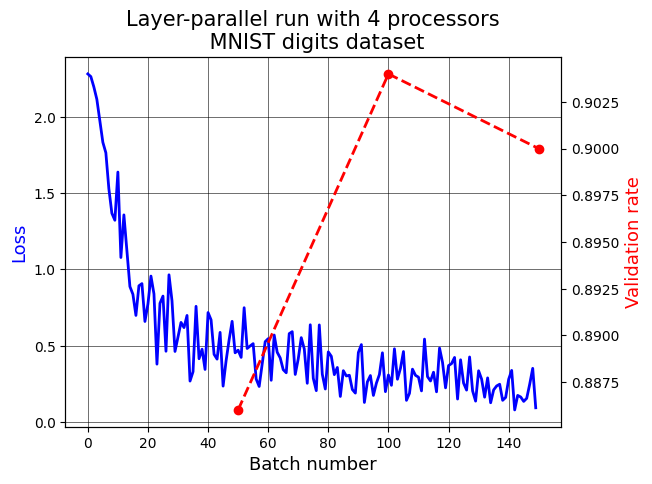

In [17]:
%%px
from matplotlib import pyplot as plt
%matplotlib inline

# plot the loss, validation 
root_print(rank, f'\nMin batch time:   {"{:.3f}".format(np.min(batch_times))} ')
root_print(rank, f'Mean batch time:  {"{:.3f}".format(stats.mean(batch_times))} ')


if rank == 0:
  fig, ax1 = plt.subplots()
  plt.title('Layer-parallel run with %d processors\n MNIST digits dataset'%(procs), fontsize=15)
  ax1.plot(batch_losses, color='b', linewidth=2)
  ax1.grid(True, color='k', linestyle='-', linewidth=0.4)
  ax1.set_xlabel(r"Batch number", fontsize=13)
  ax1.set_ylabel(r"Loss", fontsize=13, color='b')
  
  ax2 = ax1.twinx()
  epoch_points = np.arange(1, len(validat_correct_counts)+1) * len(train_loader)
  validation_percentage = np.array(validat_correct_counts) / validat_size
  ax2.plot( epoch_points, validation_percentage, color='r', linestyle='dashed', linewidth=2, marker='o')
  ax2.set_ylabel(r"Validation rate", fontsize=13, color='r')
